In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Imports

In [2]:
# basic imports
import pandas as pd
import numpy as np
import missingno as msno

# show pipeline
from sklearn import set_config
# impute
from sklearn.impute import SimpleImputer
# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
# hyper parameter turning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
# feature selection
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
# metrics used
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# plotting imports
from pandas.plotting import boxplot
from pandas.plotting import bootstrap_plot
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to sumbit to competition

In [3]:
def sumbit_to_competition(model):
    test_set = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
    pred = model.predict(test_set)

    submission = pd.DataFrame({"id": range(0,test_set.shape[0]), "target": pred}) 

    submission.to_csv('submission.csv',index=False)
    print(submission.head(5)) # just check

# Model 0 (DummyClassifier)

In [4]:
df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")

X = df.drop("target", axis=1)
y = df['target']

In [5]:
model = DummyClassifier().fit(X,y)
y_pred=model.predict(X)

In [6]:
f1_score(y, y_pred, average='macro')

0.4598663819822301

In [7]:
# sumbit_to_competition(model)

# Read train.csv

In [8]:
df_train = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
# have a explore set
explore_df = df_train

# EDA

## Data Overview

In [9]:
explore_df.shape

(39211, 16)

In [10]:
explore_df.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [11]:
explore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [12]:
explore_df['target'].value_counts()

target
no     33384
yes     5827
Name: count, dtype: int64

In [13]:
explore_df.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


## Missing Data

In [14]:
explore_df.isna().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [15]:
explore_df.isna().sum() *100 / len(explore_df)

last contact date     0.000000
age                   0.000000
job                   0.584020
marital               0.000000
education             3.741297
default               0.000000
balance               0.000000
housing               0.000000
loan                  0.000000
contact              26.359950
duration              0.000000
campaign              0.000000
pdays                 0.000000
previous              0.000000
poutcome             75.109026
target                0.000000
dtype: float64

<Axes: >

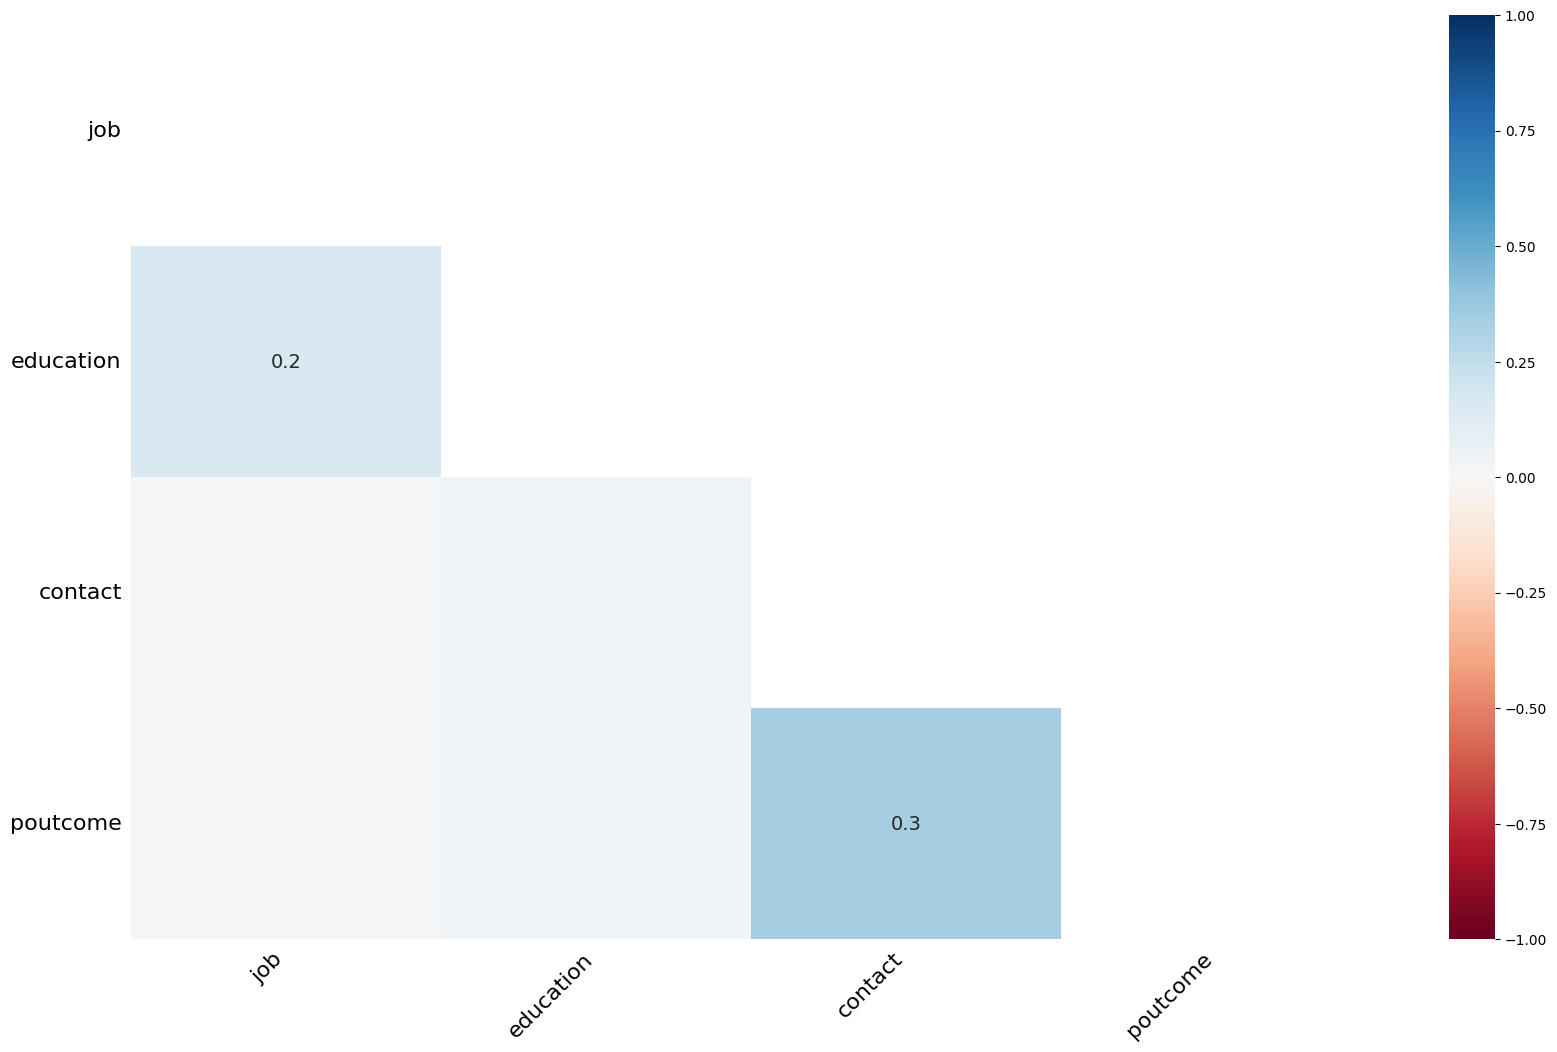

In [16]:
msno.heatmap(explore_df)

## Categorical Data

In [17]:
categorical_df = explore_df.select_dtypes(include=['object'])
categorical_df.head()

,last contact date,job,marital,education,default,housing,loan,contact,poutcome,target
0,2009-04-17,blue-collar,married,secondary,no,yes,no,cellular,other,no
1,2009-10-11,technician,married,secondary,no,yes,no,telephone,NaN,no
2,2010-11-20,blue-collar,married,secondary,no,no,no,cellular,NaN,no
3,2009-09-01,admin.,married,secondary,no,yes,no,telephone,NaN,no
4,2008-01-29,entrepreneur,single,tertiary,no,no,no,cellular,NaN,no


In [18]:
categorical_df.describe()

,last contact date,job,marital,education,default,housing,loan,contact,poutcome,target
count,39211,38982,39211,37744,39211,39211,39211,28875,9760,39211
unique,1013,11,3,3,2,2,2,2,3,2
top,2009-05-15,blue-collar,married,secondary,no,yes,no,cellular,failure,no
freq,313,7776,22691,19584,36954,21657,31820,25030,4949,33384


In [19]:
explore_df[categorical_df.columns[8]].value_counts() # can iterate through the categorical columns

poutcome
failure    4949
other      2560
success    2251
Name: count, dtype: int64

<Axes: xlabel='job'>

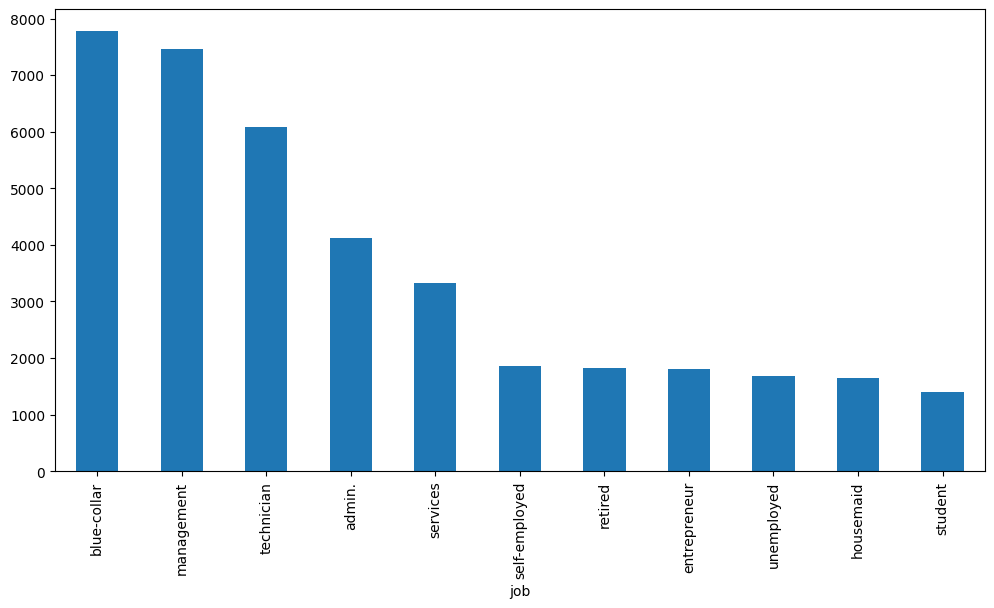

In [20]:
categorical_df[categorical_df.columns[1]].value_counts().plot(kind='bar', figsize=(12, 6)) # can iterate through the categorical columns

## Numerical Data

In [21]:
numerical_df = explore_df.select_dtypes(include=['int64'])
num_att_list = numerical_df.columns
numerical_df.head()

,age,balance,duration,campaign,pdays,previous
0,26,647,357,2,331,1
1,52,553,160,1,-1,0
2,44,1397,326,1,-1,0
3,33,394,104,3,-1,0
4,31,137,445,2,-1,0


In [22]:
numerical_df.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>]], dtype=object)

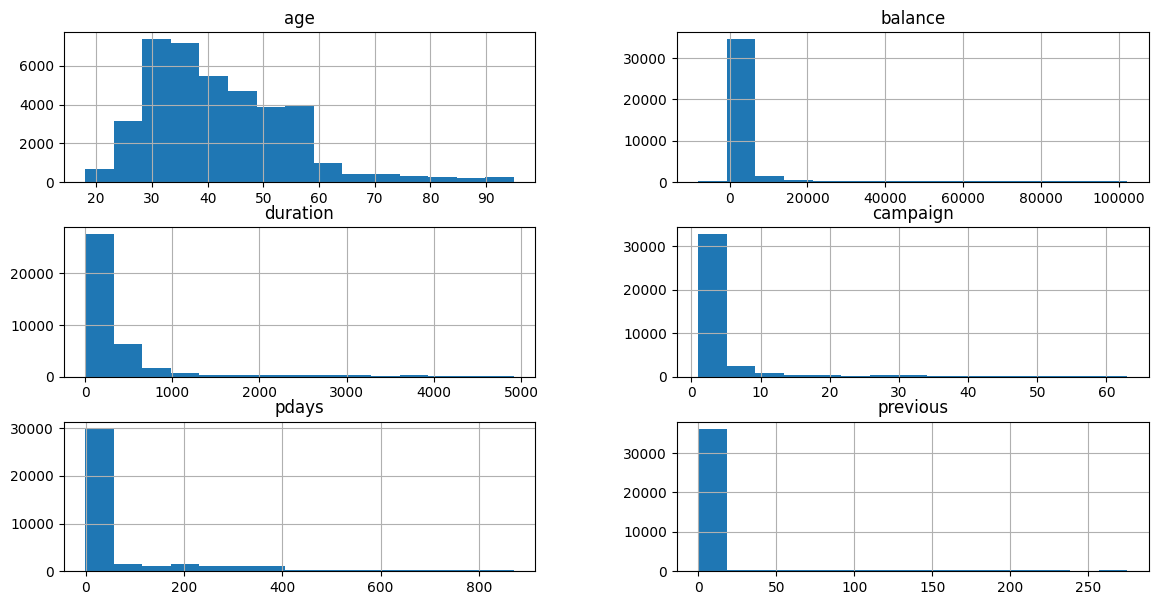

In [23]:
explore_df[num_att_list].hist(bins=15, figsize=(14, 7))

<Axes: >

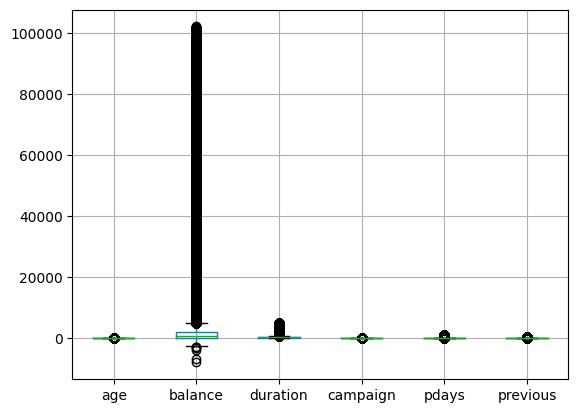

In [24]:
explore_df.boxplot(column=list(num_att_list)) #maybe do it for all saparately

## Correlation

In [25]:
corr = explore_df[numerical_df.columns].corr()
corr

,age,balance,duration,campaign,pdays,previous
age,1.000000,0.289150,0.255573,0.269439,0.199507,0.277487
balance,0.289150,1.000000,0.669737,0.674339,0.562097,0.716816
duration,0.255573,0.669737,1.000000,0.630944,0.527020,0.683951
campaign,0.269439,0.674339,0.630944,1.000000,0.519469,0.689211
pdays,0.199507,0.562097,0.527020,0.519469,1.000000,0.586175
previous,0.277487,0.716816,0.683951,0.689211,0.586175,1.000000


<Axes: >

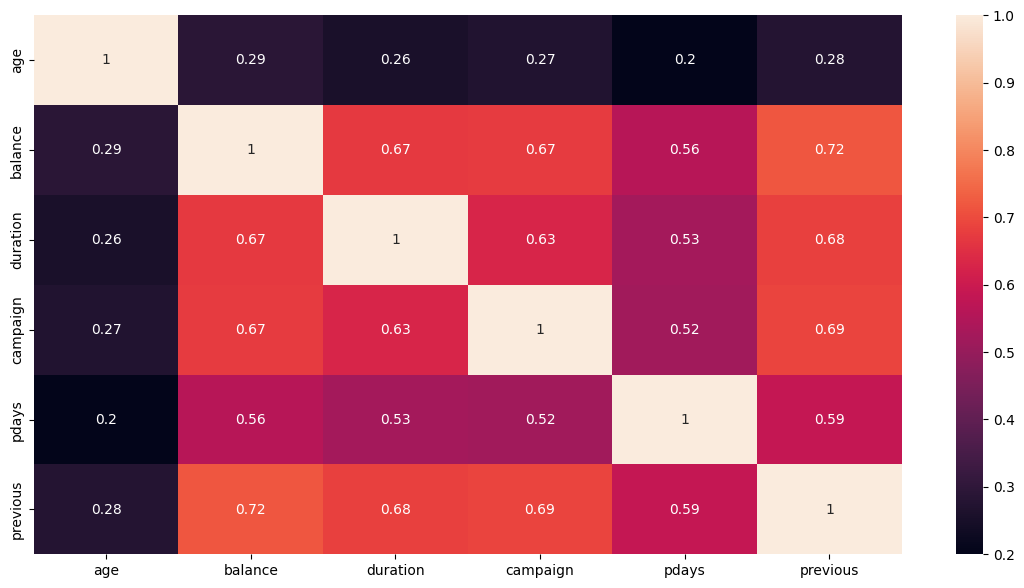

In [26]:
plt.figure(figsize = (14,7))
sns.heatmap(corr, annot = True)

## Relationships

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='balance', ylabel='age'>,
        <Axes: xlabel='duration', ylabel='age'>,
        <Axes: xlabel='campaign', ylabel='age'>,
        <Axes: xlabel='pdays', ylabel='age'>,
        <Axes: xlabel='previous', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='balance'>,
        <Axes: xlabel='balance', ylabel='balance'>,
        <Axes: xlabel='duration', ylabel='balance'>,
        <Axes: xlabel='campaign', ylabel='balance'>,
        <Axes: xlabel='pdays', ylabel='balance'>,
        <Axes: xlabel='previous', ylabel='balance'>],
       [<Axes: xlabel='age', ylabel='duration'>,
        <Axes: xlabel='balance', ylabel='duration'>,
        <Axes: xlabel='duration', ylabel='duration'>,
        <Axes: xlabel='campaign', ylabel='duration'>,
        <Axes: xlabel='pdays', ylabel='duration'>,
        <Axes: xlabel='previous', ylabel='duration'>],
       [<Axes: xlabel='age', ylabel='campaign'>,
        <Axes: xlabel='balance', ylabel

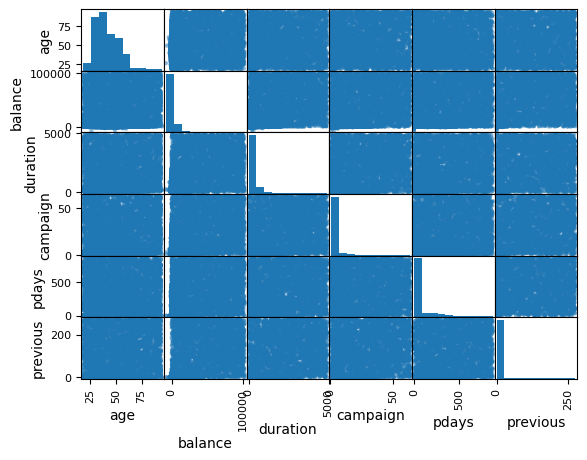

In [27]:
scatter_matrix(explore_df[num_att_list])

## Unique

In [28]:
explore_df.nunique()

last contact date    1013
age                    78
job                    11
marital                 3
education               3
default                 2
balance              9535
housing                 2
loan                    2
contact                 2
duration             3146
campaign               63
pdays                 865
previous              276
poutcome                3
target                  2
dtype: int64

## Dups

In [29]:
explore_df.duplicated().value_counts() # it shows target only so no dups

False    39211
Name: count, dtype: int64

## Bootstrap plot

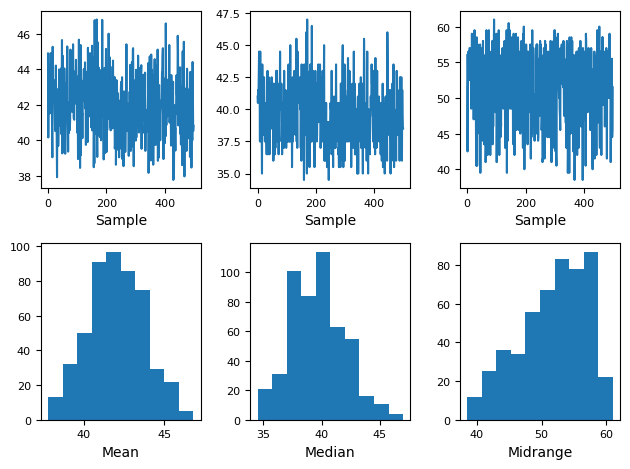

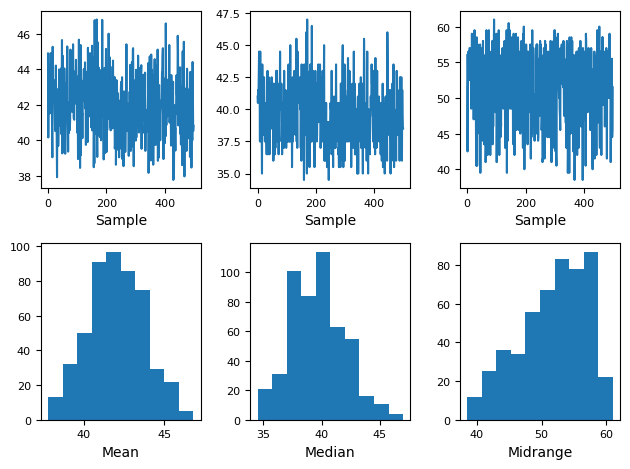

In [30]:
bootstrap_plot(explore_df['age']) # tried it out for all num_att_list

## test and sample submission

In [31]:
df_test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
df_test.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


In [32]:
df_sample = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")
df_sample.shape

(10000, 2)

# Preprocessing

In [33]:
# le = LabelEncoder()
# y = le.fit_transform(df_train['target']) # not needed
y = df_train['target']
X = df_train.drop(columns=['target'], inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

print(df_train.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(39211, 16)
(31368, 15) (31368,)
(7843, 15) (7843,)


The `DateTransformer` custom transformer converts date strings into numerical features by extracting the year, month, and day, making it easier for the model to process. It’s included in the preprocessing pipeline to handle the "last contact date" column.\

Different scalers are used to match the data’s characteristics: `StandardScaler` for age (to standardize values), `RobustScaler` for balance and pdays (to handle outliers), and `MinMaxScaler` for duration, campaign, and previous (to scale values between 0 and 1, ensuring better model performance).

In [34]:
# Custom transformer for date splitting
class DateTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer for converting date strings into numerical features.
    Handles both DataFrame and Series inputs, with proper error handling.
    """
    def __init__(self, date_format='%Y-%m-%d'):
        self.date_format = date_format
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert to pandas Series if DataFrame is passed
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0]
        
        # Convert to datetime
        dates = pd.to_datetime(X, format=self.date_format)
        
        # Extract features
        year = dates.dt.year.astype(int)
        month = dates.dt.month.astype(int)
        day = dates.dt.day.astype(int)
                
        return np.column_stack([year, month, day])

preprocessing_pipe = ColumnTransformer(
    transformers=[
        # Handle nan values and then encode categorical columns
        ('drop_column', 'drop', ['poutcome']),
        
        # Pipeline for 'job' column: imputing missing values and then one-hot encoding
        ('job_pipeline', Pipeline([
            ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('onehot', OneHotEncoder(sparse_output=False))
        ]), ['job']),
        
        # Pipeline for 'education' column: imputing most frequent and ordinal encoding
        ('education_pipeline', Pipeline([
            ('impute_most_frequent', SimpleImputer(strategy='most_frequent')),
            ('ordinal', OrdinalEncoder())
        ]), ['education']),
        
        # Pipeline for 'contact' column: imputing most frequent and one-hot encoding
        ('contact_pipeline', Pipeline([
            ('impute_most_frequent', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(sparse_output=False))
        ]), ['contact']),
        
        # Pipeline for binary features: one-hot encoding
        ('binary_pipeline', OneHotEncoder(drop='if_binary'), ['default', 'housing', 'loan']),
        
        # Pipeline for marital status: one-hot encoding
        ('marital_pipeline', OneHotEncoder(sparse_output=False), ['marital']),
        
        # Scaling numerical features
        ('age_scaler', StandardScaler(), ['age']),
        ('balance_scaler', RobustScaler(), ['balance', 'pdays']),
        ('duration_scaler', MinMaxScaler(), ['duration', 'campaign', 'previous']),
        # ('gendral_scaling', MinMaxScaler(), ['age', 'balance', 'pdays', 'duration', 'campaign', 'previous'])
        
        # Handel date
        ('date_transformer', DateTransformer(), ['last contact date'])
    ]
)

In [35]:
# config display
set_config(display='diagram')
preprocessing_pipe

ColumnTransformer(transformers=[('drop_column', 'drop', ['poutcome']),
                                ('job_pipeline',
                                 Pipeline(steps=[('impute_unknown',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['job']),
                                ('education_pipeline',
                                 Pipeline(steps=[('impute_most_frequent',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  Ordi...
                                 OneHotEncoder(drop='if_binary'),
                                 ['default', 'housing', 'loan']),
                                ('marital_pipeline',
                                 OneHotEncoder(sparse_output=False),
                                 ['marital']),
                                ('age_scaler', StandardScaler(), ['age']),
                                ('balance_scaler', RobustScaler(),
                                 ['balance', 'pdays']),
                                ('duration_scaler', MinMaxScaler(),
                                 ['duration', 'campaign', 'previous']),
                                ('date_transformer', DateTransformer(),
                                 ['last contact date'])])

In [36]:
X_train_pre = preprocessing_pipe.fit_transform(X_train)
len(X_train_pre[0])

30

# Model 1 (LogisticRegression)

**It looks like Linear Regression might not be the best fit for this problem, as it's struggling to capture the complexity of the data. We might need to try something more suited for classification**

In [37]:
model_pipe_lr = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('rf_model', LogisticRegression(random_state=42, solver='liblinear', max_iter=2000))
])
# Warning: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT. so increasing max_iter

In [38]:
lr_model = model_pipe_lr.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)

In [39]:
f1_score(y_test, lr_y_pred, average='macro')

0.5702014678354299

In [40]:
# sumbit_to_competition(lr_model)

## Hyperparameter tuning (using LogisticRegressionCV)

In [41]:
model_pipe_logistic = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('logistic_model', LogisticRegressionCV(
        Cs=[0.01, 0.1, 1, 10, 100],
        cv=5,                       
        penalty='l2',
        scoring='f1_macro',
        max_iter=2000,
        random_state=42 
    ))
])

In [42]:
# take some time so commented

# lr_cv_model = model_pipe_logistic.fit(X_train, y_train)
# lr_cv_y_pred = lr_cv_model.predict(X_test)

In [43]:
# f1_score(y_test, lr_cv_y_pred, average='macro')

# 0.571717512040596

In [44]:
# sumbit_to_competition(lr_cv_model)

# Model 2 (KNN)

**KNN isn’t a good fit because it struggles with imbalanced classes, leading to biased predictions toward the majority class.**

In [45]:
knn_model_pipe = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('knn_model', KNeighborsClassifier())
])

In [46]:
knn_model = knn_model_pipe.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)

In [47]:
f1_score(y_test, knn_y_pred, average='macro')

0.63788367289247

In [48]:
# sumbit_to_competition(knn_model)

## Hyperpaameter tuning 

number of neighbors(n_neighbors): Adjusting the number of neighbors helps balance sensitivity to local patterns, improving classification accuracy.  `weight*: Switching between`unifor` and`distanc` allows the model to prioritize closer neighbors, potentially enhancing predictions for imbalanced classes.

In [49]:
knn_param_grid = {
    'knn_model__n_neighbors': [3, 5, 7],
    'knn_model__weights': ['uniform', 'distance'],
}

In [50]:
# don't take long but affect the submission time so commenting
# knn_grid_search = GridSearchCV(knn_model_pipe, knn_param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)
# knn_grid_search.fit(X_train, y_train)

# print(knn_grid_search.best_estimator_)
# print(knn_grid_search.best_params_)
# print(knn_grid_search.best_score_)

# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# Pipeline(steps=[('preprocess',
#                  ColumnTransformer(transformers=[('drop_column', 'drop',
#                                                   ['poutcome']),
#                                                  ('job_pipeline',
#                                                   Pipeline(steps=[('impute_unknown',
#                                                                    SimpleImputer(fill_value='unknown',
#                                                                                  strategy='constant')),
#                                                                   ('onehot',
#                                                                    OneHotEncoder(sparse_output=False))]),
#                                                   ['job']),
#                                                  ('education_pipeline',
#                                                   Pipeline(steps=[('impute_most_frequent',
#                                                                    SimpleImputer(strategy='mo...
#                                                    'loan']),
#                                                  ('marital_pipeline',
#                                                   OneHotEncoder(sparse_output=False),
#                                                   ['marital']),
#                                                  ('age_scaler',
#                                                   StandardScaler(), ['age']),
#                                                  ('balance_scaler',
#                                                   RobustScaler(),
#                                                   ['balance', 'pdays']),
#                                                  ('duration_scaler',
#                                                   MinMaxScaler(),
#                                                   ['duration', 'campaign',
#                                                    'previous']),
#                                                  ('date_transformer',
#                                                   DateTransformer(),
#                                                   ['last contact date'])])),
#                 ('knn_model', KNeighborsClassifier(n_neighbors=3))])
# {'knn_model__n_neighbors': 3, 'knn_model__weights': 'uniform'}
# 0.6452301167267829

In [51]:
gridcv_knn_model_pipe = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('knn_model', KNeighborsClassifier(n_neighbors=3))
])

In [52]:
gridcv_knn_model = gridcv_knn_model_pipe.fit(X_train, y_train)
gridcv_knn_y_pred = gridcv_knn_model.predict(X_test)

In [53]:
f1_score(y_test, gridcv_knn_y_pred, average='macro')

0.6386156845062445

In [54]:
# sumbit_to_competition(gridcv_knn_model)

## Evaluate the model

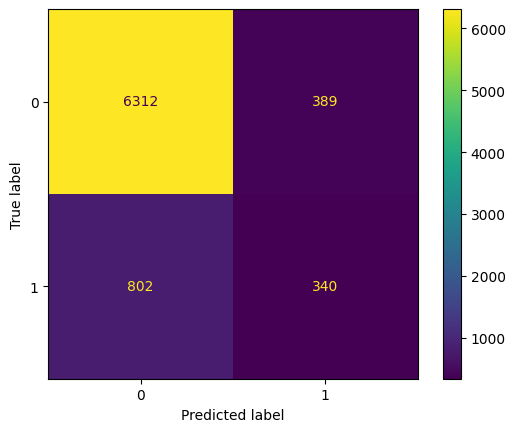

In [55]:
cm = confusion_matrix(y_test, gridcv_knn_y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [56]:
print(classification_report(y_test, gridcv_knn_y_pred))

              precision    recall  f1-score   support

          no       0.89      0.94      0.91      6701
         yes       0.47      0.30      0.36      1142

    accuracy                           0.85      7843
   macro avg       0.68      0.62      0.64      7843
weighted avg       0.83      0.85      0.83      7843



# Model 3 (RandomForestClassifier)

**RandomForestClassifier has more potential because it can handle complex, non-linear relationships and automatically manage both numerical and categorical features for classification**

In [57]:
rf_model_pipe = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('rf_model', RandomForestClassifier())
])

In [58]:
rf_model = rf_model_pipe.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

In [59]:
f1_score(y_test, rf_y_pred, average='macro')

0.6998504631631305

In [60]:
# sumbit_to_competition(rf_model)

## Hyperparameter tuning 

**tried to use all the important parameters**\
Number of Trees (rf_model__n_estimators): Controls how many trees the forest has; more trees usually improve predictions but increase training time.
Tree Depth (rf_model__max_depth): Limits how deep each tree can grow—shallow trees are faster and avoid overfitting, while deeper trees capture more complexity.\
Minimum Samples to Split (rf_model__min_samples_split): Sets the minimum samples needed to split a node; higher values make the model less prone to overfitting.\
Minimum Samples per Leaf (rf_model__min_samples_leaf): Ensures leaves have enough data to be meaningful, reducing overfitting.\
Features Considered at Each Split (rf_model__max_features): Decides how many features to look at when splitting; 'sqrt' and 'log2' make splits faster and more robust, while None uses all features.

In [61]:
rf_param_grid = {
    'rf_model__n_estimators': [100, 200, 300],
    'rf_model__max_depth': [None, 10, 20, 30],        
    'rf_model__min_samples_split': [2, 5, 10],        
    'rf_model__min_samples_leaf': [1, 2, 4],          
    'rf_model__max_features': ['sqrt', 'log2', None]  
}

### GridSearchCV 
**It takes too long**

In [62]:
# taking too long will try later
# rf_grid_search = GridSearchCV(rf_model_pipe, rf_param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)
# rf_grid_search.fit(X_train, y_train)

# print(rf_grid_search.best_estimator_)
# print(rf_grid_search.best_params_)

In [63]:
# # using randomcv to get best hyperparameters using it directly
# gridcv_model_pipe = Pipeline([
#     ('preprocess', preprocessing_pipe),
#     ('rf_model_randomcv', RandomForestClassifier(
#                                             max_features=None, 
#                                             min_samples_split=10,
#                                             n_estimators=300)
#     )
# ])
# gridcv_rf_model = gridcv_model_pipe.fit(X_train, y_train)
# gridcv_rf_model

In [64]:
# gridcv_rf_y_pred = gridcv_rf_model.predict(X_test)
# f1_score(y_test, gridcv_rf_y_pred, average='macro')

### RandomizedSearchCV
**Takes a decent amount of time**

In [65]:
# # commented it out because it will take more time to run
# rf_grid_search = RandomizedSearchCV(rf_model_pipe, rf_param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=1, n_iter=50)
# rf_grid_search.fit(X_train, y_train)

# print(rf_grid_search.best_estimator_)
# print(rf_grid_search.best_params_)

In [66]:
# # commented it out because it depends on randomcv
# randomcv_best_model = rf_random_search_pipe[-1].best_estimator_
# randomcv_rf_model = randomcv_best_model.fit(X_train, y_train)
# randomcv_rf_model

In [67]:
# used randomcv to get best hyperparameters using it directly
randomcv_model_pipe = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('rf_model_randomcv', RandomForestClassifier(
                                        max_depth=20, 
                                        max_features=None,
                                        min_samples_leaf=2,
                                        n_estimators=300,
                                        class_weight='balanced')
    )
])
randomcv_rf_model = randomcv_model_pipe.fit(X_train, y_train)
randomcv_rf_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('drop_column', 'drop',
                                                  ['poutcome']),
                                                 ('job_pipeline',
                                                  Pipeline(steps=[('impute_unknown',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['job']),
                                                 ('education_pipeline',
                                                  Pipeline(steps=[('impute_most_frequent',
                                                                   SimpleImputer(strategy='mo...
                                                  StandardScaler(), ['age']),
                                                 ('balance_scaler',
                                                  RobustScaler(),
                                                  ['balance', 'pdays']),
                                                 ('duration_scaler',
                                                  MinMaxScaler(),
                                                  ['duration', 'campaign',
                                                   'previous']),
                                                 ('date_transformer',
                                                  DateTransformer(),
                                                  ['last contact date'])])),
                ('rf_model_randomcv',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        max_features=None, min_samples_leaf=2,
                                        n_estimators=300))])

In [68]:
randomcv_rf_y_pred = randomcv_rf_model.predict(X_test)
f1_score(y_test, randomcv_rf_y_pred, average='macro')

0.7509795171806135

In [69]:
sumbit_to_competition(randomcv_rf_model)

   id target
0   0     no
1   1     no
2   2     no
3   3     no
4   4    yes


## Feature Selection (no significant improvements)

In [70]:
# X_train_preprocess = preprocessing_pipe.fit_transform(X_train)

# model = RandomForestClassifier(
#     max_depth=20, 
#     max_features=None,
#     min_samples_leaf=2,
#     n_estimators=300,
#     class_weight='balanced')

# rfecv = RFECV(estimator=model, step=1, cv=5, scoring='f1_macro', n_jobs=-1)

# rfecv_randomcv_rf_model = rfecv.fit(X_train_preprocess, y_train)
# rfecv_randomcv_rf_model

In [71]:
# print("Maximum CV score:", rfecv_randomcv_rf_model.cv_results_['mean_test_score'].max())
# print("Number of features for maximum score:", rfecv_randomcv_rf_model.n_features_)

# Maximum CV score: 0.75119119115497
# Number of features for maximum score: 7

In [72]:
# rfecv_randomcv_rf_model.support_
# array([False, False, False, False, False, False, False, False, False,
#        False, False, False, False, False, False, False,  True, False,
#        False, False, False,  True,  True,  True,  True, False, False,
#        False,  True,  True])


## Dimensionality Reduction (f1 score drops)

In [73]:
rf_model_pipe_with_pca = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('pca', PCA(n_components=0.95)),
    ('rf_model', RandomForestClassifier(
        max_depth=20, 
        max_features=None,
        min_samples_leaf=2,
        n_estimators=300,
        class_weight='balanced'
    ))
])

pca = rf_model_pipe_with_pca.fit(X_train, y_train)
pca

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('drop_column', 'drop',
                                                  ['poutcome']),
                                                 ('job_pipeline',
                                                  Pipeline(steps=[('impute_unknown',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['job']),
                                                 ('education_pipeline',
                                                  Pipeline(steps=[('impute_most_frequent',
                                                                   SimpleImputer(strategy='mo...
                                                  StandardScaler(), ['age']),
                                                 ('balance_scaler',
                                                  RobustScaler(),
                                                  ['balance', 'pdays']),
                                                 ('duration_scaler',
                                                  MinMaxScaler(),
                                                  ['duration', 'campaign',
                                                   'previous']),
                                                 ('date_transformer',
                                                  DateTransformer(),
                                                  ['last contact date'])])),
                ('pca', PCA(n_components=0.95)),
                ('rf_model',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        max_features=None, min_samples_leaf=2,
                                        n_estimators=300))])

In [74]:
pca_y_pred = pca.predict(X_test)
f1_score(y_test, pca_y_pred, average='macro')

0.6317031528077206

## Evaluate the model

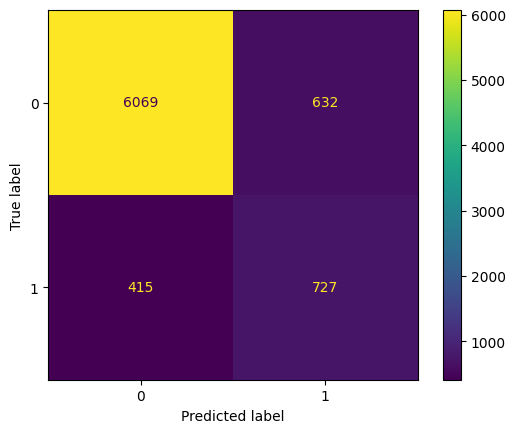

In [75]:
cm = confusion_matrix(y_test, randomcv_rf_y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [76]:
print(classification_report(y_test, randomcv_rf_y_pred))

              precision    recall  f1-score   support

          no       0.94      0.91      0.92      6701
         yes       0.53      0.64      0.58      1142

    accuracy                           0.87      7843
   macro avg       0.74      0.77      0.75      7843
weighted avg       0.88      0.87      0.87      7843



# Model 4 (HistGradientBoostingClassifier)

**The HistGradientBoostingClassifier is highly efficient for large datasets as it uses histogram-based binning, making it faster and more memory-efficient while achieving state-of-the-art predictive performance**

In [77]:
hgbc_model_pipe = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('hgbc_model', HistGradientBoostingClassifier(class_weight='balanced'))
])

In [78]:
hgbc_model = hgbc_model_pipe.fit(X_train, y_train)
hgbc_y_pred = hgbc_model.predict(X_test)

In [79]:
f1_score(y_test, hgbc_y_pred, average='macro')

0.7486403373784494

In [80]:
# sumbit_to_competition(hgbc_model)

## Hyperparameter tuning (using GridSearchCV)

**Constructed a simple grid**\
Learning Rate (rf_model__learning_rate): Keeps the updates small and steady, helping the model avoid overfitting.\
Number of Iterations (rf_model__max_iter): Controls how many trees are built; more trees can boost accuracy but take longer.\
Tree Depth (rf_model__max_depth): Limits how deep each tree can go, so it doesn’t overfit by memorizing the data.\
Minimum Samples per Leaf (rf_model__min_samples_leaf): Makes sure each leaf has enough data to generalize better.\

In [81]:
hgbc_param_grid = {
    'hgbc_model__learning_rate': [0.05, 0.1],
    'hgbc_model__max_iter': [100, 200],
    'hgbc_model__max_depth': [5, 10],
    'hgbc_model__min_samples_leaf': [10, 20],
}

In [82]:
# commenting because it takes sometime
# hgbc_grid_search = GridSearchCV(hgbc_model_pipe, hgbc_param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)
# hgbc_grid_search.fit(X_train, y_train)

# print(hgbc_grid_search.best_estimator_)
# print(hgbc_grid_search.best_params_)
# print(hgbc_grid_search.best_score_)

# Fitting 5 folds for each of 16 candidates, totalling 80 fits
# Pipeline(steps=[('preprocess',
#                  ColumnTransformer(transformers=[('drop_column', 'drop',
#                                                   ['poutcome']),
#                                                  ('job_pipeline',
#                                                   Pipeline(steps=[('impute_unknown',
#                                                                    SimpleImputer(fill_value='unknown',
#                                                                                  strategy='constant')),
#                                                                   ('onehot',
#                                                                    OneHotEncoder(sparse_output=False))]),
#                                                   ['job']),
#                                                  ('education_pipeline',
#                                                   Pipeline(steps=[('impute_most_frequent',
#                                                                    SimpleImputer(strategy='mo...
#                                                   OneHotEncoder(sparse_output=False),
#                                                   ['marital']),
#                                                  ('age_scaler',
#                                                   StandardScaler(), ['age']),
#                                                  ('balance_scaler',
#                                                   RobustScaler(),
#                                                   ['balance', 'pdays']),
#                                                  ('duration_scaler',
#                                                   MinMaxScaler(),
#                                                   ['duration', 'campaign',
#                                                    'previous']),
#                                                  ('date_transformer',
#                                                   DateTransformer(),
#                                                   ['last contact date'])])),
#                 ('hgbc_model',
#                  HistGradientBoostingClassifier(class_weight='balanced',
#                                                 max_depth=10,
#                                                 min_samples_leaf=10))])
# {'hgbc_model__learning_rate': 0.1, 'hgbc_model__max_depth': 10, 'hgbc_model__max_iter': 100, 'hgbc_model__min_samples_leaf': 10}
# 0.7547413736470273

In [83]:
gridcv_hgbc_model_pipe = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('gridcv_hgbc_model', HistGradientBoostingClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=10))
])

In [84]:
gridcv_hgbc_model = gridcv_hgbc_model_pipe.fit(X_train, y_train)
gridcv_hgbc_y_pred = gridcv_hgbc_model.predict(X_test)

In [85]:
f1_score(y_test, gridcv_hgbc_y_pred, average='macro')

0.7485051456006881

In [86]:
# sumbit_to_competition(gridcv_hgbc_model)